In [2]:
import warnings

warnings.filterwarnings("ignore")

# Learning goals
After today's lesson you should be able to:
- Use cross-validation
- Find the best model for classification and regression problems based on tuning hyperparameters and calculating performance scores

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from pysal.lib import weights


## 0.1 Import the data

For this exercise, let's use the San Diego AirBnB data set again. As a reminder: This dataset contains house intrinsic characteristics, both continuous (number of beds as in `beds`) and categorical (type of renting or, in Airbnb jargon, property group as in the series of `pg_X` binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, `d2balboa` or neighborhood id, `neighborhood_cleansed`).


Our aim here is to predict the **`log_price`** (Regression) of an AirBnB. 

In [4]:
db = gpd.read_file("https://www.dropbox.com/s/zkucu7jf1xug869/regression_db.geojson?dl=1")


In [5]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

In [6]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


Again, notice here that we have: 
- **Discrete variables** (number of bedrooms, beds, baths)
- **Dummy variables** (whether there is a pool, whether near the coast, room type)

# 1. `log_price`
Let's start off with predicting the price of the Airbnb. 


In [7]:
y = db['log_price']

## We'll make our X, independent variables, the "kitchen sink" of all of our other variables for now. 
## I'm using all the variables we have available with the exception of `neighborhood`, which we have to turn into dummy variables in a second. 

X = db[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'pool',
       'd2balboa', 'coastal', 'pg_Apartment',
       'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse',
       'rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room']]

## 1.1 Feature engineering
Feature engineering is the process of creating new variables from the ones you already have. Common feature engineering tasks include:
- Creating dummy variables from categorical variables
- Creating interaction terms between variables
- Creating polynomial terms from variables
- Creating log or square root terms from variables
- Creating lagged variables from time series data or lagged spatial variables 


In [9]:
neighborhood_dummies = pd.get_dummies(db['neighborhood'])

In [10]:
neighborhood_dummies.head()

,Balboa Park,Bay Ho,Bay Park,Carmel Valley,City Heights West,Clairemont Mesa,College Area,Core,Cortez Hill,Del Mar Heights,...,Park West,Rancho Bernadino,Rancho Penasquitos,Roseville,San Carlos,Scripps Ranch,Serra Mesa,South Park,University City,West University Heights
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [11]:
## Here, I want to concatenate my X and neighborhood_dummies into one dataframe.
## I need to tell pd.concat() to either add new columns (axis=1) or add new rows (axis=0).
## The default is axis=0, ie new rows, so I need to specify axis=1.
X = pd.concat([X, neighborhood_dummies],axis=1)

In [12]:
X.head()

,accommodates,bathrooms,bedrooms,beds,pool,d2balboa,coastal,pg_Apartment,pg_Condominium,pg_House,...,Park West,Rancho Bernadino,Rancho Penasquitos,Roseville,San Carlos,Scripps Ranch,Serra Mesa,South Park,University City,West University Heights
0,5,2.0,2.0,2.0,0,2.972077,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,6,1.0,2.0,4.0,0,11.501385,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1.0,1.0,1.0,0,2.493893,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1.0,1.0,1.0,0,22.293757,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2,1.0,1.0,1.0,0,6.829451,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


Let's also create a new column that is the KNN spatial lag for the 'neighborhood context'. Here, I'm going to use the columns: 
- `pool`, which is a binary (0,1) variable for whether the airbnb has a pool
- `pg_House` which is a binary (0,1) variable for whether the airbnb is a house

I will choose K=20, to give me the 20 closest neighboring Airbnbs. My spatial lag should be a number between 0 and 20 to estimate, of the 20 closest Airbnb, how many have pools and how many are other housees.

In [13]:
knn = weights.KNN.from_dataframe(db, k=20)

In [14]:
pool_lag = weights.lag_spatial(knn, db['pool'])
house_lag = weights.lag_spatial(knn, db['pg_House'])

Add these to new features to our original data. 

In [15]:
X['pool_lag'] = pool_lag
X['house_lag'] = house_lag


## 1.1 Create our Train-Test Split
We almost always start off with splitting our data into our **train** and **test** sets. 

In [16]:
from sklearn.model_selection import train_test_split

## Let's use the default split for now, which is 75-25 train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,)


## 1.2 Predict the data
Here, let's use a decision tree regressor to predict the price. 

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Use the permutation importance function from sklearn.inspection
from sklearn.inspection import permutation_importance


In [18]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

RandomForestRegressor()

## 1.3 Cross-validation
Now we use the k-fold cross-validation method is run our model several times on different parts of the training data. 

In [19]:
## The default scoring metric for Random Forest is R^2, so we can use cross_val_score() to get the R^2 for each fold.
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.70156982, 0.71532608, 0.69726636, 0.69682176, 0.69465989])

As you can see, there is some variation here. 

In [20]:
scores.mean()

0.7011287832913642

## 1.4 Test score 
Let's see how well our model does on the test data. 

In [21]:
# evaluate the model on the second set of data
ypred_rf = model.predict(X_test)
print("R^2 is:", r2_score(y_test, ypred_rf))
print("Mean absolute error is:", mean_absolute_error(y_test, ypred_rf))
print("Mean squared error is:", mean_squared_error(y_test, ypred_rf))

R^2 is: 0.6927999048332064
Mean absolute error is: 0.32259338127690323
Mean squared error is: 0.19628738651402966


## 1.5 Feature Importance for the Test Set
Note: You can also estimate the importance for the training set, but generally we're interested in performance for new data (test set). 

### 1.5.1 Impurity based feature importance

In [22]:
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)


In [23]:
importances

array([3.67834816e-02, 1.11760850e-01, 4.47077042e-01, 1.63901117e-02,
       7.22824479e-03, 8.68229578e-02, 1.63578616e-02, 9.17109059e-03,
       4.48138974e-03, 5.00453376e-03, 1.38360716e-02, 2.29119500e-03,
       9.03103613e-02, 1.12268572e-02, 6.26782140e-03, 1.29108082e-03,
       3.10681389e-04, 5.87624638e-04, 7.16184916e-04, 1.19442726e-03,
       3.99480139e-04, 9.74242652e-04, 1.03615386e-03, 1.69407882e-03,
       1.02197254e-03, 2.13912632e-03, 3.28120542e-03, 1.57125385e-03,
       6.10864721e-04, 4.01413572e-04, 5.70645820e-03, 4.15187811e-04,
       1.30258553e-03, 3.66699256e-03, 1.21841831e-03, 2.63290926e-03,
       2.03428931e-03, 2.33100964e-03, 7.54818325e-04, 2.27444794e-03,
       1.16682736e-04, 2.75141767e-03, 9.25243518e-04, 5.28955439e-04,
       2.30742611e-03, 5.12543653e-04, 1.07925590e-03, 1.58504784e-03,
       2.33947601e-04, 2.67150192e-03, 1.24317395e-03, 1.00460480e-03,
       2.01243644e-04, 8.92946591e-04, 6.97600041e-04, 3.92763704e-04,
      

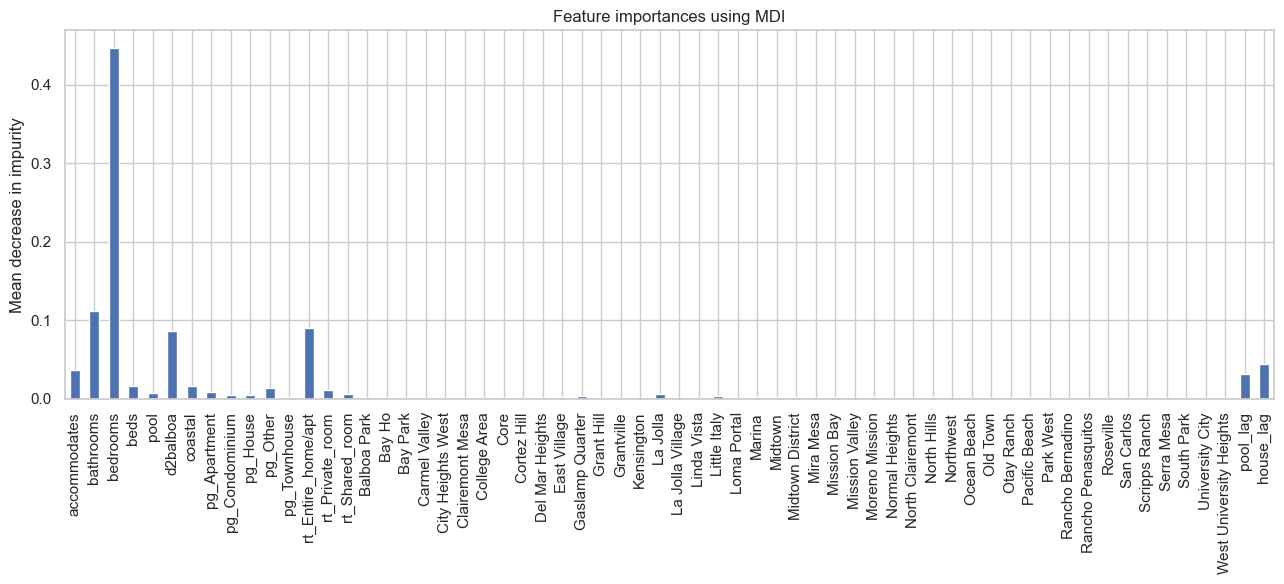

In [24]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=(13,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


### 1.5.2 Permutation based feature importance
This will take a few seconds because we have to reshuffle each column!

In [25]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

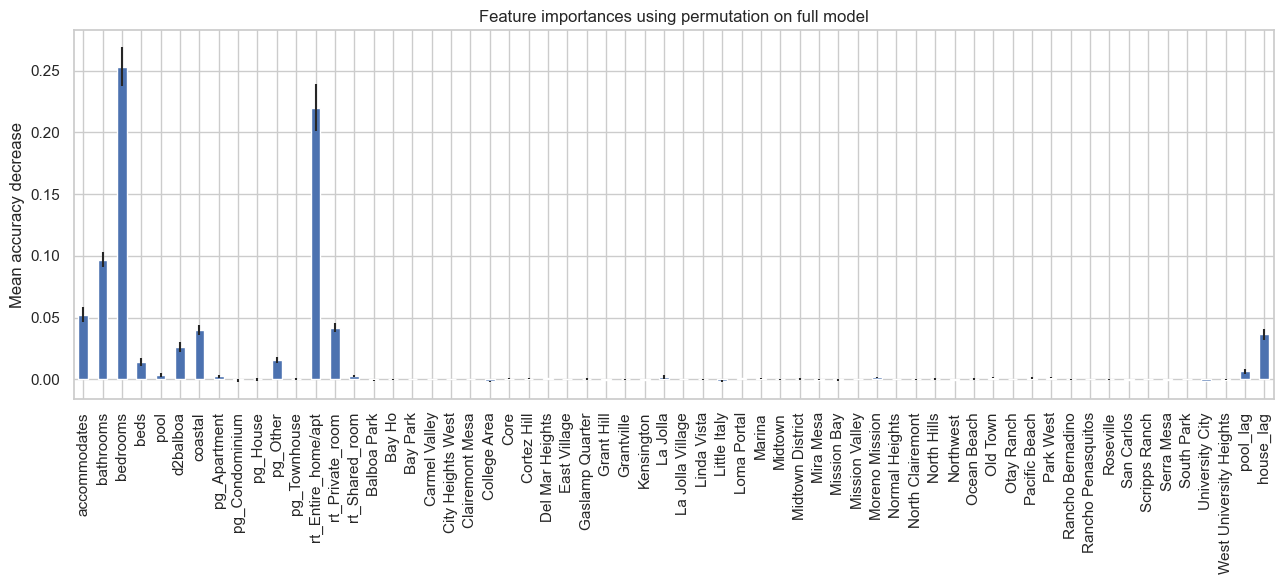

In [26]:
fig, ax = plt.subplots(figsize=(13,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Q.1 Feature Importances 
Tune the hyperparameters on your model and measure the feature importances using the impurity and permutation based feature importances. Did your importances change? (5 pts)

In [41]:
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,)

### Tune Hyperparameters

Here we tune the `max_depth` parameter of our model. I'm choosing to use a Decision Tree model instead of a Random Forest for this excercise. 

In [42]:
trees = np.linspace(1,20,20).astype(int)

In [44]:
mean_scores_train = []
mean_scores_test = []

## Now, let's loop through our trees and get the mean score for each
for t in trees: 
    model = DecisionTreeRegressor(max_depth=t)
    model.fit(X_train, y_train)
    scores_train = cross_val_score(model, X_train, y_train, cv=5)
    
    ypred_rf = model.predict(X_test)
    score_test = r2_score(y_test, ypred_rf)

    mean_scores_train.append(scores_train.mean())
    mean_scores_test.append(score_test)

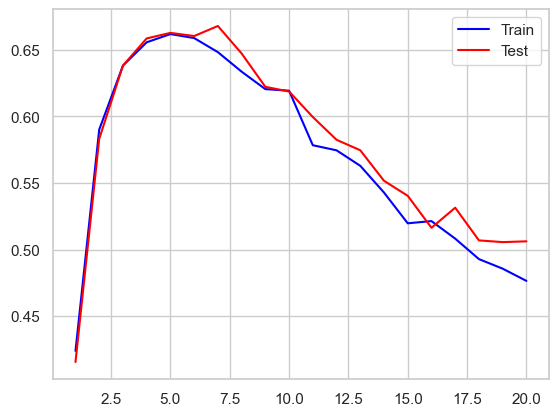

In [45]:
plt.plot(trees,mean_scores_train,color='blue',label='Train')
plt.plot(trees,mean_scores_test,color='red',label='Test')
plt.legend()

In [46]:
#Use optimal max_depth to define model
model = DecisionTreeRegressor(max_depth=5)

model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

### Impurity Feature Importance

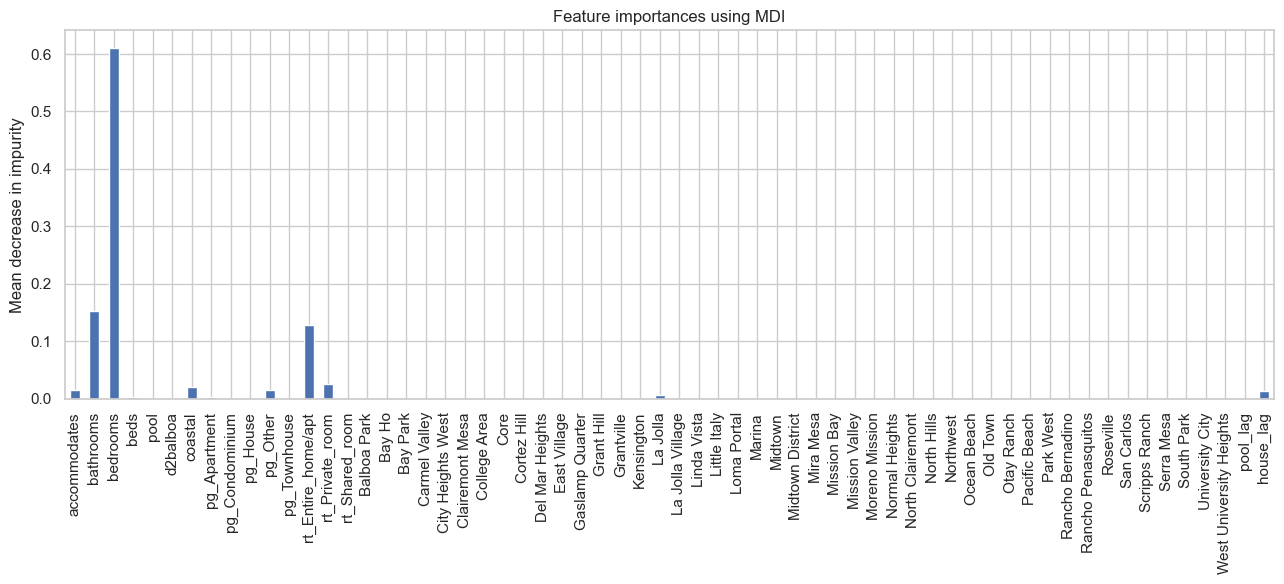

In [51]:
importances = model.feature_importances_
#np.std([model.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=(13,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Permutation Feature Importance

In [48]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

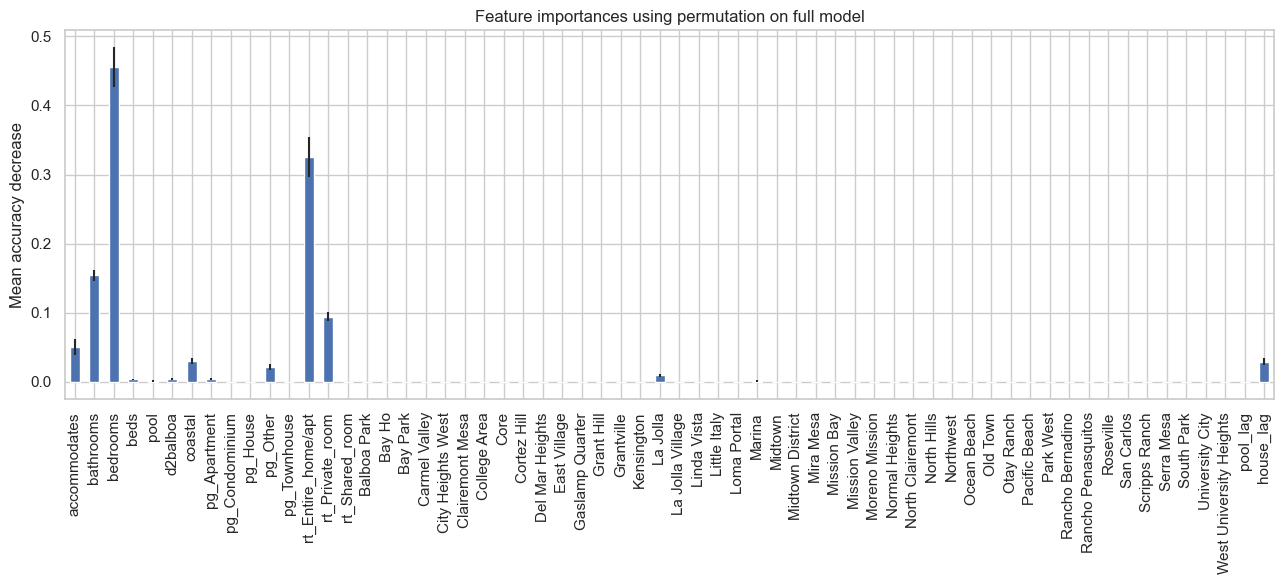

In [49]:
fig, ax = plt.subplots(figsize=(13,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Yes, the feature importance values have changed. 